In [ ]:
!pip install visualkeras
!pip install pydot
!sudo install graphviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import visualkeras
import os
import itertools
import tqdm
import random
from keras.preprocessing.image import load_img
import PIL
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

import tensorflow as tf 

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import  Activation, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import plot_model
import numpy as np
import cv2

warnings.filterwarnings('ignore')

2022-12-24 07:12:54.408966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 07:12:54.408996: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
input_path = []
label = []

for cls in os.listdir("Data"):
  for path in os.listdir(os.path.join("Data", cls)):
    if cls == 'Normal':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("Data", cls, path))
  print(input_path[0], label[0])

Data/HeatStress/1671837125.5888438.jpg 1
Data/HeatStress/1671837125.5888438.jpg 1


In [3]:
len(label)
len(input_path)

25360

In [4]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac = 1).reset_index(drop=True)
df.head()

,images,label
0,Data/HeatStress/1671837288.4452107.jpg,1
1,Data/HeatStress/1671837460.4006927.jpg,1
2,Data/Normal/1671837360.5281549.jpg,0
3,Data/Normal/1671837396.3407924.jpg,0
4,Data/Normal/1671287274.0901506.jpg,0


In [5]:
for i in df['images']:
  if '.jpg' not in i:
    print(i)


In [6]:
df = df[df['images'] != 'Data/HeatStress/Thumbs.db']
df = df[df['images'] != 'Data/Normal/Thumbs.db']
df = df[df['images'] != 'Data/HeatStress/11702.jpg']
df = df[df['images'] != 'Data/Normal/666.jpg']

len(df)

25360

In [7]:


l = []

for image in df['images']:
  try:
    img = PIL.Image.open(image)
  except Exception as e:
    l.append(image)

l


[]

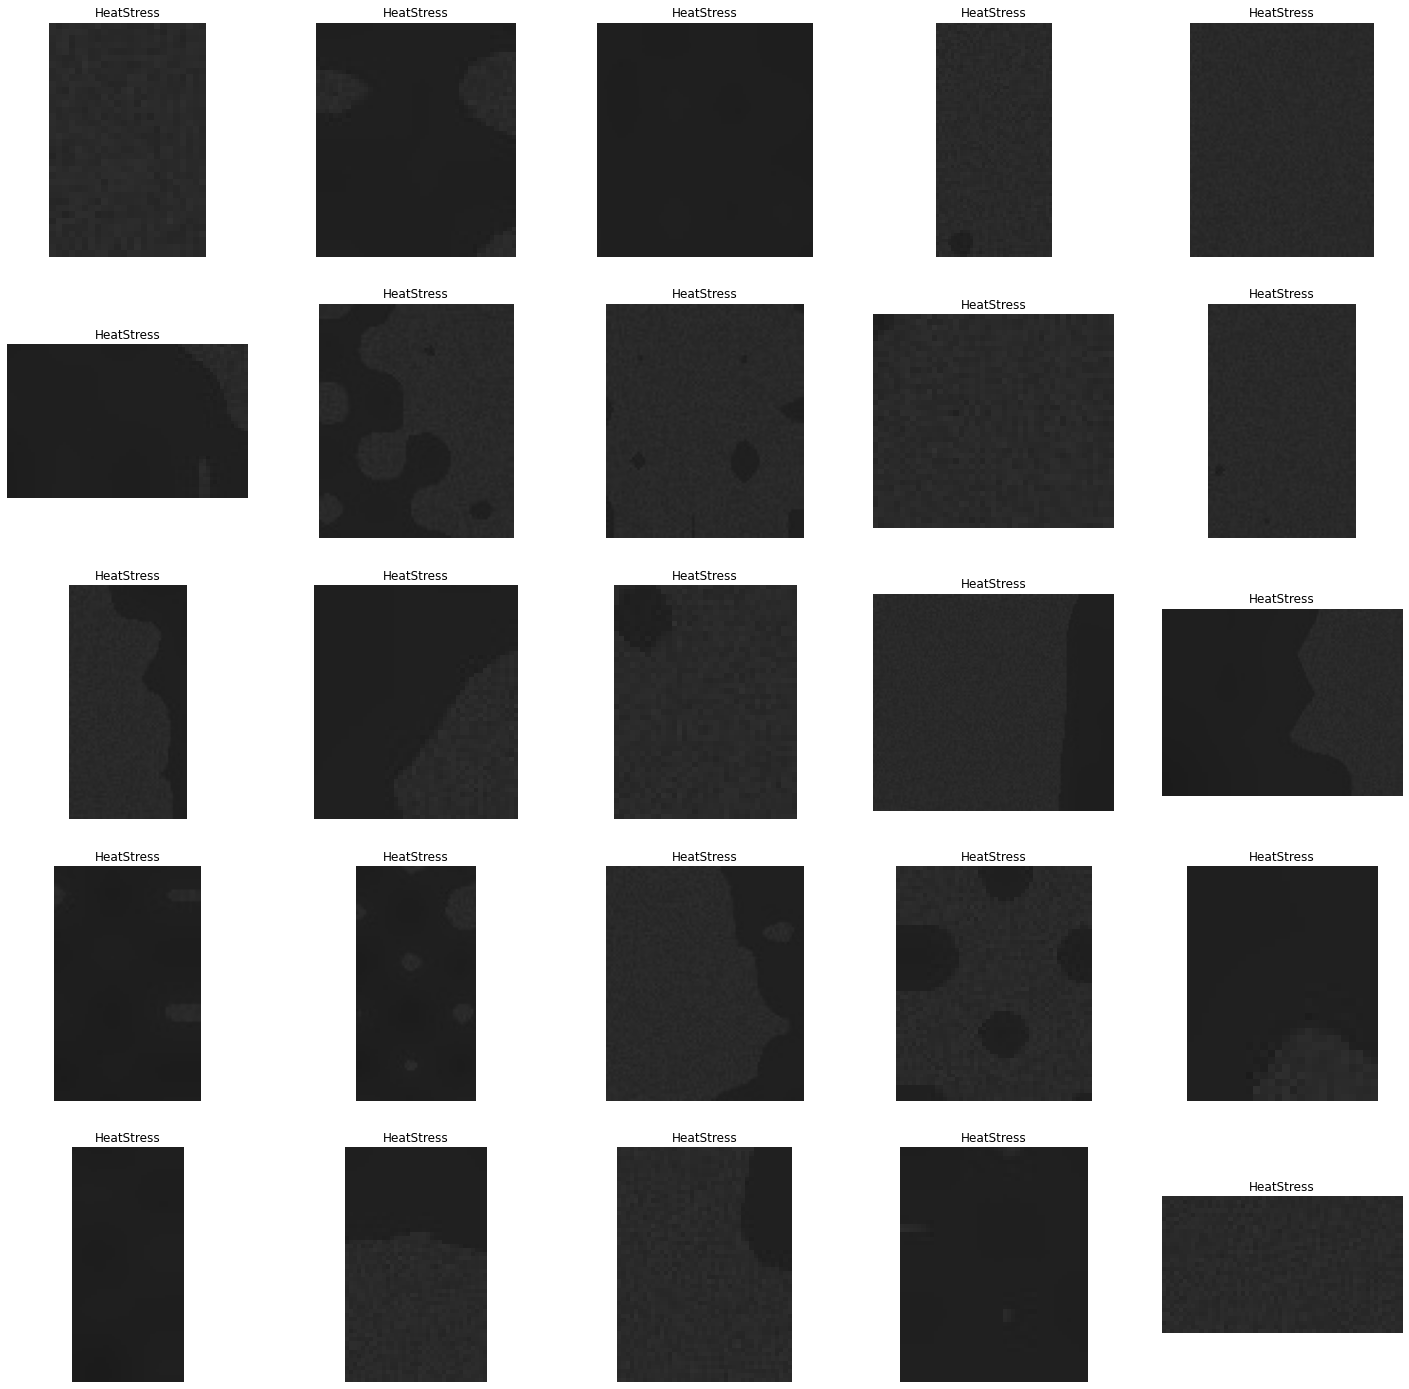

In [8]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('HeatStress')
  plt.axis('off')
plt.savefig("HeatStress Figures.jpg")
  

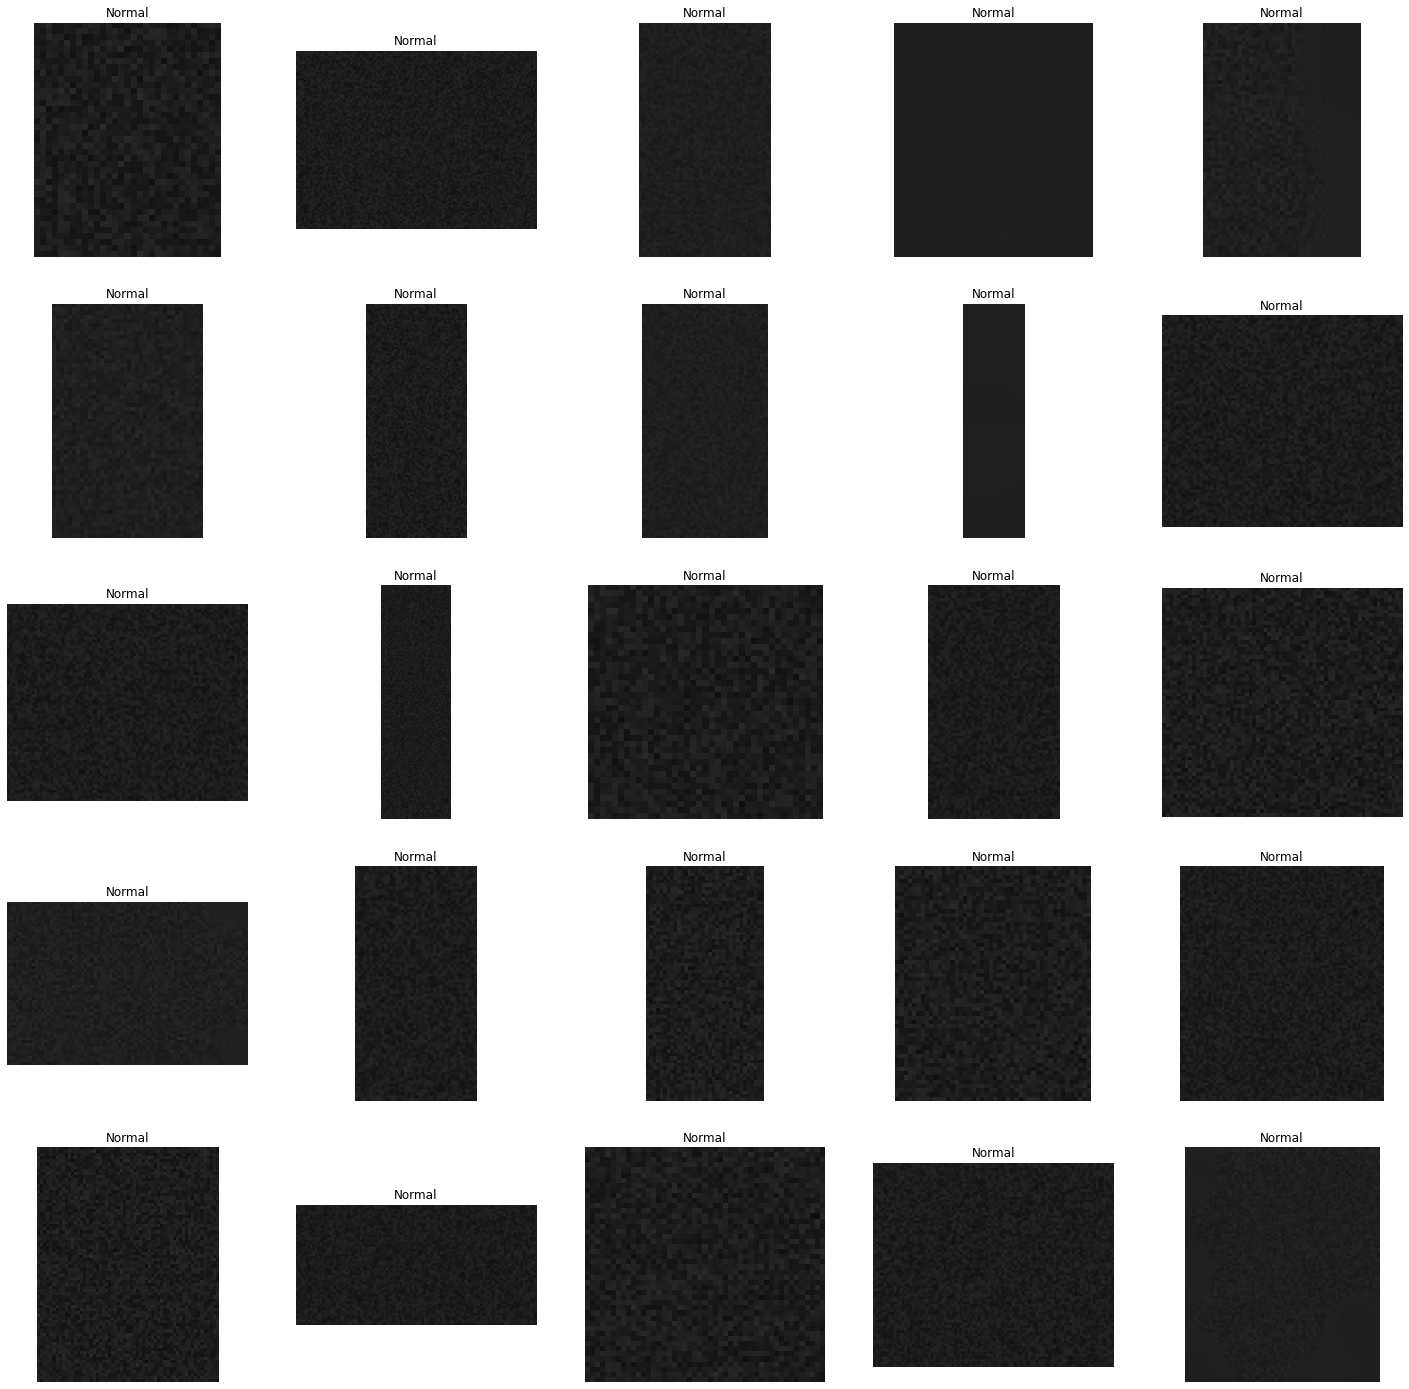

In [9]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Normal')
  plt.axis('off')
plt.savefig("Normal Figures.jpg")

<AxesSubplot:xlabel='label', ylabel='count'>

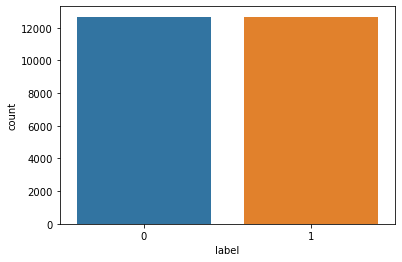

In [10]:
sns.countplot(df['label'])

In [11]:
df['label'] = df['label'].astype('str')

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.head()

,images,label
11192,Data/Normal/1671289238.0315511.jpg,0
15172,Data/HeatStress/1671837121.7184103.jpg,1
7449,Data/HeatStress/1671287162.0242667.jpg,1
2247,Data/HeatStress/1671837453.6505582.jpg,1
14804,Data/Normal/1671289243.6427078.jpg,0


In [13]:


train_generator=ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    fill_mode='nearest'
)


val_generator = ImageDataGenerator(
    rescale=1./255
)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary',
    color_mode="grayscale",
    
    )

val_iterator = train_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary',
    color_mode="grayscale",
    
    )

print(tf.shape(val_iterator.next()[0]))

Found 20288 validated image filenames belonging to 2 classes.
Found 5072 validated image filenames belonging to 2 classes.
tf.Tensor([512 128 128   1], shape=(4,), dtype=int32)


2022-12-24 07:35:49.747553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jerbee/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-24 07:35:49.747594: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-24 07:35:49.747622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jerbee-HP-Notebook): /proc/driver/nvidia/version does not exist
2022-12-24 07:35:49.793986: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 07:35:4

In [14]:
def mai_Net():
    model = tf.keras.models.Sequential([
                                        Conv2D(16, (2,2), activation='relu', input_shape=(128,128, 1)),
                                        MaxPool2D((2,2)),
                                        Conv2D(32, (2,2), activation='relu'),
                                        MaxPool2D((2,2)),
                                        Conv2D(64,(3,3), activation='relu'),
                                        MaxPool2D((2,2)),
                                        Flatten(),
                                        Dense(512, activation='relu'),
                                        Dense(1, activation='sigmoid')
    ])

    return model

model = mai_Net()

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [17]:
#@title
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

2022-12-24 07:36:55.741410: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.


Epoch 1/10


2022-12-24 07:36:58.660455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.
2022-12-24 07:36:58.720978: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-24 07:36:58.989478: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.


40/40 [==============================] - 154s 4s/step - loss: 0.3594 - accuracy: 0.8417 - val_loss: 0.0877 - val_accuracy: 0.9562
Epoch 2/10
40/40 [==============================] - 143s 4s/step - loss: 0.0929 - accuracy: 0.9568 - val_loss: 0.0973 - val_accuracy: 0.9570
Epoch 3/10
40/40 [==============================] - 144s 4s/step - loss: 0.0810 - accuracy: 0.9620 - val_loss: 0.0919 - val_accuracy: 0.9570
Epoch 4/10
40/40 [==============================] - 151s 4s/step - loss: 0.0860 - accuracy: 0.9608 - val_loss: 0.0811 - val_accuracy: 0.9600
Epoch 5/10
40/40 [==============================] - 177s 4s/step - loss: 0.0930 - accuracy: 0.9571 - val_loss: 0.0976 - val_accuracy: 0.9582
Epoch 6/10
40/40 [==============================] - 165s 4s/step - loss: 0.0766 - accuracy: 0.9648 - val_loss: 0.0802 - val_accuracy: 0.9618
Epoch 7/10
40/40 [==============================] - 173s 4s/step - loss: 0.0826 - accuracy: 0.9625 - val_loss: 0.0758 - val_accuracy: 0.9629
Epoch 8/10
40/40 [======

<Figure size 432x288 with 0 Axes>

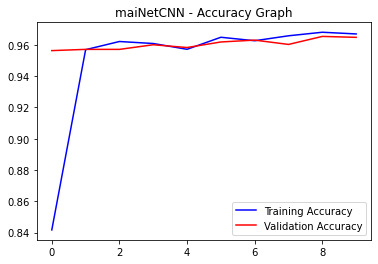

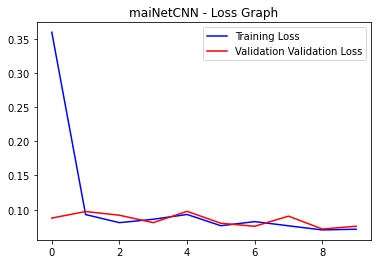

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc,'b', label='Training Accuracy')
plt.plot(epochs, val_acc,'r', label='Validation Accuracy')
plt.title('maiNetCNN - Accuracy Graph')
plt.legend()
plt.savefig("maiNetCNN - Accuracy Graph.jpg")
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss,'b', label='Training Loss')
plt.plot(epochs, val_loss,'r', label='Validation Validation Loss')
plt.title('maiNetCNN - Loss Graph')
plt.legend()
plt.savefig("maiNetCNN - Loss Graph.jpg")
plt.figure()


In [19]:
model.save('mai_Net2_dec24_96.4perc.h5')
# model = tf.keras.models.load_model('mai_Net2.h5')

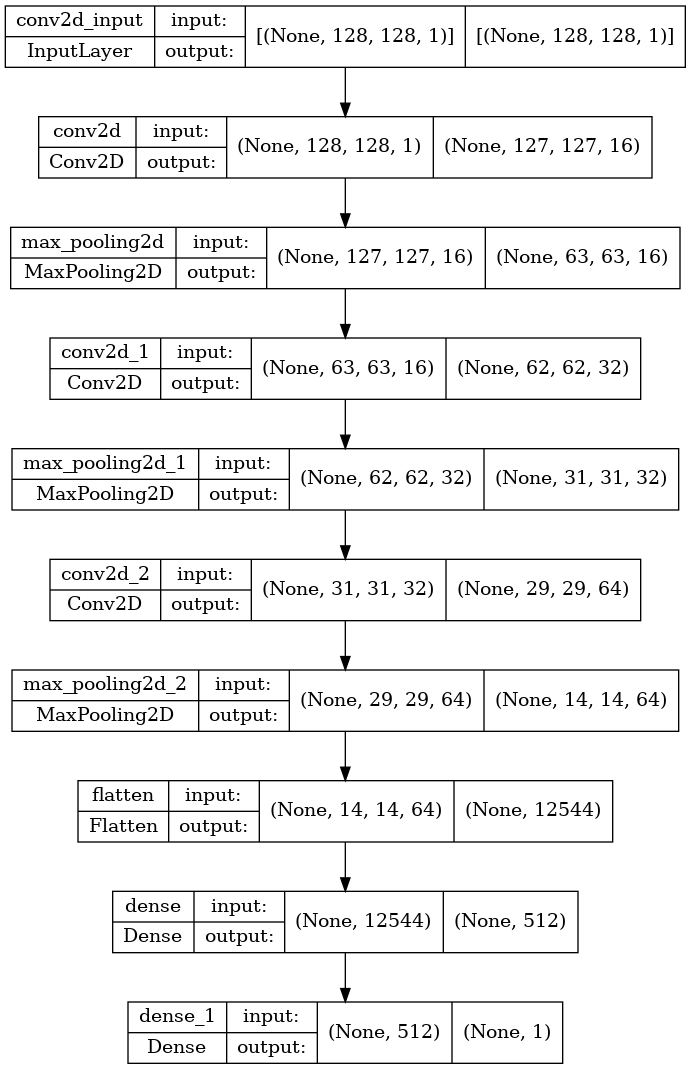

In [22]:
plot_model(model, to_file='Mai_Net_CNN.png', show_shapes=True)

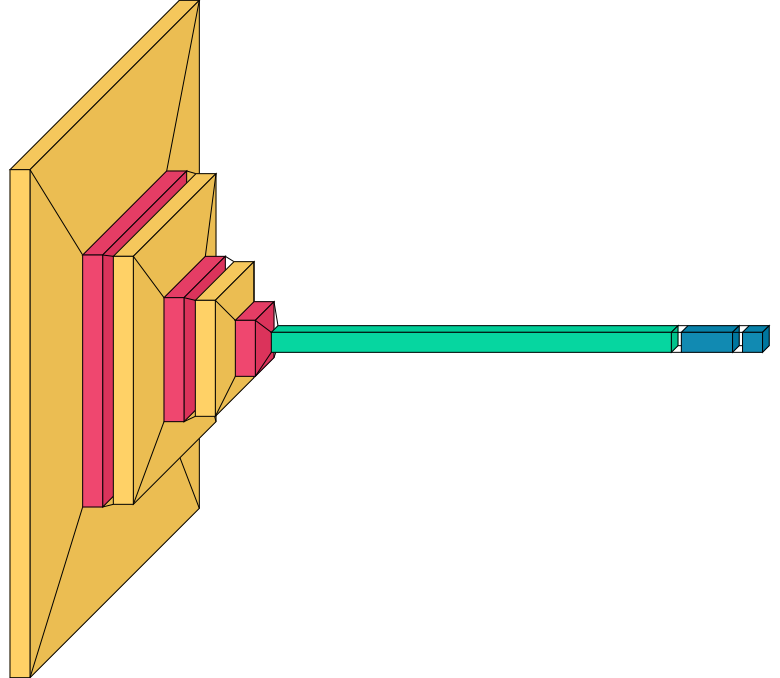

In [21]:
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='mai_net CNN - visualized.png').show() # write and show
visualkeras.layered_view(model)

In [25]:
paths=["testNormal", "testHeatStress"]
targ = 0
target = os.listdir(paths[targ])
classes = ["NormalDesu", "HeatStress"]

norms = 0
heats = 0

for img in target:
    full_path = os.path.join(paths[targ],img )
#     numpy image -> keras image tensor
#     img = tf.keras.preprocessing.image.load_img(full_path, target_size=(128, 128), color_mode='grayscale')
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor /= 255. 
#     print(img_tensor.shape)
    
    res = model.predict(np.array(img_tensor).reshape(-1, 128, 128, 1))
    sres = np.squeeze(res)
    rsres = round(float(sres))
    print(f"{classes[rsres]} -> {full_path}")
    
    if rsres == 0 : norms += 1
    else : heats += 1
        
print(f"Normal : {norms} - Heats : {heats}")
#     arged = np.argmax(res)
#     result = classes[np.argmax(np.squeeze(res))]
#     print(f" Model Result -> {result}")

    
# for img in normal:
#     imgg = cv2.imread(os.path.join("testNormal",img), cv2.IMREAD_GRAYSCALE)
#     imgg = cv2.resize(imgg, (128, 128))/255.0
#     res = model.predict(np.array(imgg).reshape(-1, 128, 128, 1))

#     result = classes[np.argmax(np.squeeze(res))]
# #     if res[0][0] > .50: result = "HeatStress"
# #     else: result = "Normal"
    
#     print(f"Totest -> {img}, Model Result -> {np.argmax(np.squeeze(res))}, Identification -> {result}")


NormalDesu -> testNormal/noraml1669874563.0029411.jpg
NormalDesu -> testNormal/noraml1669874561.2592492.jpg
NormalDesu -> testNormal/noraml1669874561.077049.jpg
NormalDesu -> testNormal/noraml1669874561.4090576.jpg
NormalDesu -> testNormal/noraml1669874562.9061685.jpg
NormalDesu -> testNormal/noraml1669874561.345571.jpg
NormalDesu -> testNormal/noraml1669874562.399357.jpg
NormalDesu -> testNormal/noraml1669874562.5046961.jpg
NormalDesu -> testNormal/noraml1669874562.684121.jpg
HeatStress -> testNormal/noraml1669874562.055913.jpg
HeatStress -> testNormal/noraml1669874562.6516476.jpg
NormalDesu -> testNormal/noraml1669874562.0315547.jpg
HeatStress -> testNormal/noraml1669874561.4954429.jpg
NormalDesu -> testNormal/noraml1669874561.9033673.jpg
NormalDesu -> testNormal/noraml1669874561.3128002.jpg
NormalDesu -> testNormal/noraml1669874562.335993.jpg
NormalDesu -> testNormal/noraml1669874562.007765.jpg
NormalDesu -> testNormal/noraml1669874562.8195415.jpg
HeatStress -> testNormal/noraml1669